In [21]:
import copy
import datetime as dt
from pathlib import Path
import pickle
import requests
import warnings
import sys

import holidays
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model
from sklearn import metrics
from sklearn.linear_model import Ridge
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pd.options.mode.chained_assignment = None  # default='warn'
matplotlib.rcParams.update({'font.size': 15})
warnings.simplefilter("ignore")
sys.path.insert(0, Path.cwd().parent.as_posix())

from src.utils import expand_time, gdp_countries, save_model, load_model
from src.holidays import *

In [2]:
BASE_PATH = Path.cwd().parent
DATA_PATH = BASE_PATH / "data"

train = pd.read_csv(DATA_PATH / "train.csv")
test = pd.read_csv(DATA_PATH / "test.csv")

In [3]:
DATA_PATH.absolute()

PosixPath('/Users/philippmoehl/Documents/sales_forecasting/data')

## Preprocess Data

In [4]:
df = pd.concat([train, test], axis=0)
df['log'] = np.log(df['num_sold'])

In [5]:
# create more features based on the date column
df, _ = expand_time(df)

In [6]:
# collect GDP data for countries
gdp = gdp_countries(train.country.unique())

rel_gdp_df = pd.DataFrame(gdp, index=train.country.unique(), columns=range(2017, 2023))

In [7]:
# add GDP data
df['rel_gdp'] = df.apply(lambda s: rel_gdp_df.loc[s.country, s.date.year], axis=1)
df['log_rel_gdp'] = np.log(df['rel_gdp'])

In [8]:
# gather holiday specific information
df_holidays = create_holiday(
    [2017, 2018, 2019, 2020, 2021, 2022], df.country.unique())

In [9]:
# Calculate holiday_diff
holiday_diff = calculate_holiday_diff()

# Add holidays based on holiday_diff
df["holiday"] = add_holidays(df, df_holidays, holiday_diff)

# Add special dates and get special date columns
special_date_columns = add_special_dates(df)

# Add custom holidays for specific countries
holiday_countries = ['Estonia', 'Canada']
column = 'holiday_1226'
holiday_diff = calculate_holiday_diff()

add_custom_holidays(df, holiday_countries, column, holiday_diff)

special_date_columns.append(column)

holidays_columns = ['holiday']

In [10]:
# sin wave
year_columns = ['year_sin_1', 'year_cos_1', 'year_sin_0.5', 'year_cos_0.5']
df['year_sin_1']   = np.sin(np.pi * df['time_no'] / 182.5)
df['year_cos_1']   = np.cos(np.pi * df['time_no'] / 182.5)
df['year_sin_0.5'] = np.sin(np.pi * df['time_no'] / 365.0)
df['year_cos_0.5'] = np.cos(np.pi * df['time_no'] / 365.0)

# prodcut feature.
#I did crossvalidation and find that we only need simple sin and cos wave
product_year_columns = []
for product in train['product'].unique():
    df[product] = (df['product'] == product).astype(float)
    product_sin = '{}_sin'.format(product)
    product_cos = '{}_cos'.format(product)
    if product == 'Using LLMs to Train More LLMs' or product == 'Using LLMs to Win Friends and Influence People':
        df[product_sin] = df[product] * df['year_sin_0.5']
        df[product_cos] = df[product] * df['year_cos_0.5']

        product_year_columns.append(product_sin)
        product_year_columns.append(product_cos)
    elif product == 'Using LLMs to Write Better' or product== 'Using LLMs to Improve Your Coding':
        df[product_sin] = df[product] * df['year_sin_1']
        product_year_columns.append(product_sin)    
    else:
        df[product_cos] = df[product] * df['year_cos_1']
        product_year_columns.append(product_cos)

In [11]:
# make month flag in 2020
featured_month_columns = []
for month in range(3, 11):
    column = 'month_2020_{}'.format(month)
    df[column] = ((df['year'] == 2020) & (df['month'] == month)).astype(float)
    featured_month_columns.append(column)

In [12]:
# week flag
week_columns = []
for week in range(4, 7):
    column = 'week_{}'.format(week)
    df[column] = (df['week'] == week).astype(float)
    week_columns.append(column)
store_columns = []

for store in train.store.unique()[1:]:
    column = 'store_{}'.format(store)
    df[column] = ((df['store'] == store)).astype(float)
    #df[column] = ((df['store'] == store) & (df['year'] != 2020)).astype(float)
    store_columns.append(column)
# product
product_columns = []
for product in train['product'].unique()[1:]:
    column = 'product_{}'.format(product)
    df[column] = (df['product'] == product).astype(float)
    product_columns.append(column)

## Modelling

In [13]:
# decide use columns
use_columns = []
use_columns.extend(special_date_columns)
use_columns.extend(product_year_columns)
use_columns.extend(holidays_columns)
use_columns.extend(week_columns)
use_columns.extend(store_columns)
use_columns.extend(product_columns)
use_columns.extend(featured_month_columns)


# learning
df_used = df.copy()
date = dt.datetime(2021, 12, 31)
df_used = df_used.loc[df_used['date'] <= date]
source = df_used[use_columns]
target = df_used['log']-df_used['log_rel_gdp']

In [14]:
# Model
model = Pipeline([
    ('standardize', StandardScaler()),
    ('linear_reg', Ridge(alpha=150, tol=0.00001, max_iter=10000))

])

In [15]:
# Fit model
model.fit(source, target)

Pipeline(steps=[('standardize', StandardScaler()),
                ('linear_reg', Ridge(alpha=150, max_iter=10000, tol=1e-05))])

In [19]:
# save model
save_model(model, "model_0.pkl")

## Testing

In [22]:
model = load_model("model_0.pkl")

In [23]:
# show results
df['predict_log'] = model.predict(df[use_columns])+df['log_rel_gdp']
df['predict_exp'] = np.exp(df['predict_log'])


df['smape_log'] = 2 * (df['log'] - df['predict_log']).abs() / (df['log'] + df['predict_log'])

df['smape_exp'] = 2 * (df['num_sold'] - df['predict_exp']).abs() / (df['num_sold'] + df['predict_exp'])

result = df.loc[df['date'] <= date]
print('e smape  = {}'.format(result['smape_exp'].mean()))

e smape  = 0.044295043764811304


In [24]:
result = df.sort_values('id')
result_2 = result.copy()
result_2.loc[(result_2['year'] == 2022)&(result_2['country'] == 'Argentina'), 'predict_exp'] *= 3.372
result_2.loc[(result_2['year'] == 2022)&(result_2['country'] == 'Spain'), 'predict_exp'] *= 1.6
result_2.loc[(result_2['year'] == 2022)&(result_2['country'] == 'Japan'), 'predict_exp'] *= 1.394
result_2.loc[(result_2['year'] == 2022)&(result_2['country'] == 'Estonia'), 'predict_exp'] *= 1.651
result_2.loc[(result_2['year'] == 2022)&(result_2['country'] == 'Canada'), 'predict_exp'] *= 0.850

Using LLMs to Improve Your Coding


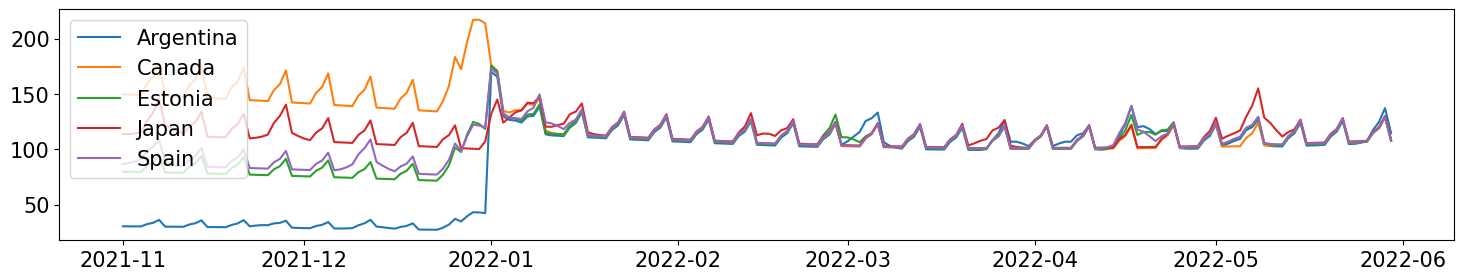

Using LLMs to Train More LLMs


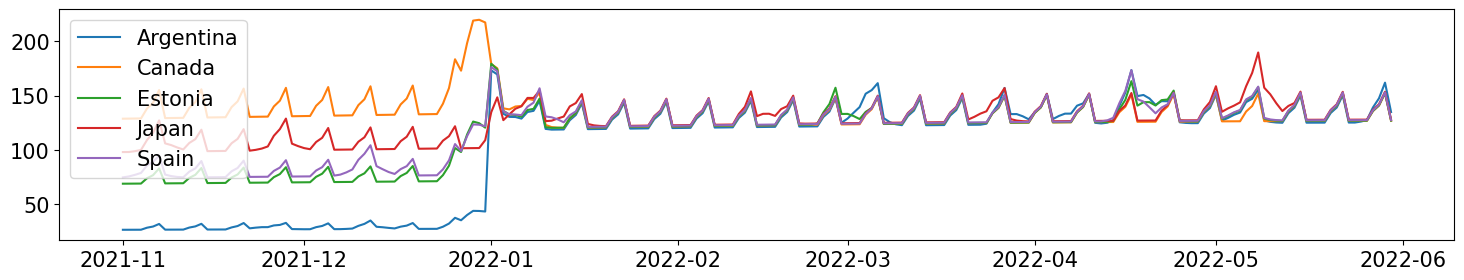

Using LLMs to Win Friends and Influence People


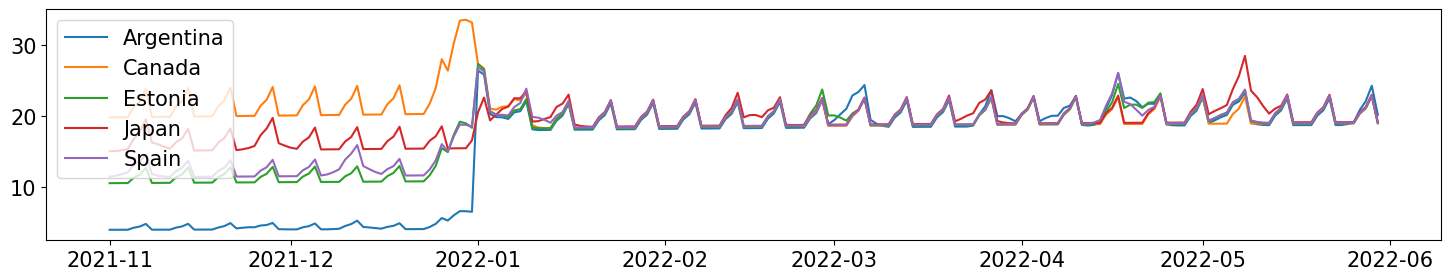

Using LLMs to Win More Kaggle Competitions


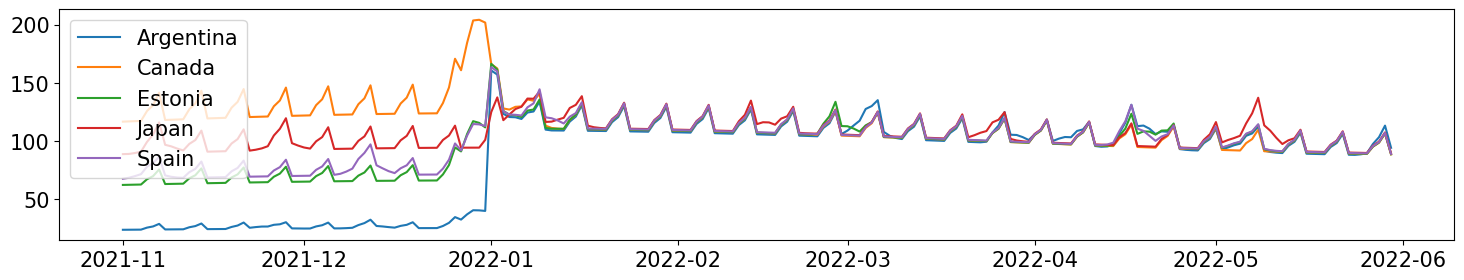

Using LLMs to Write Better


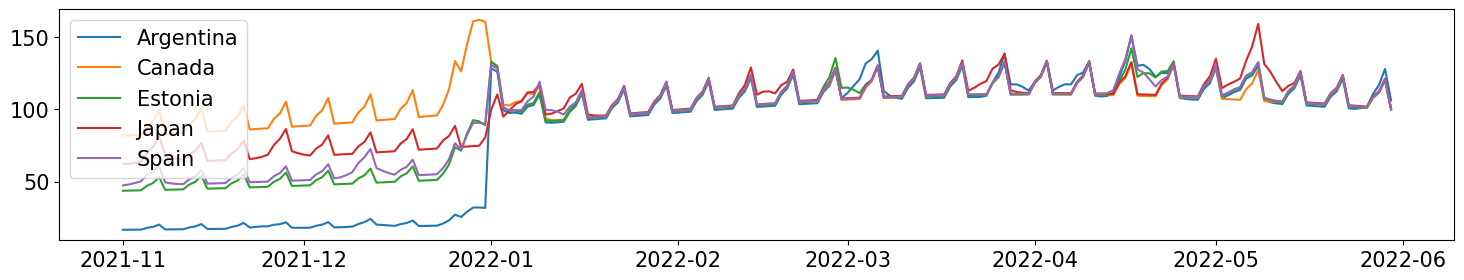

In [25]:
# First loop over products
for i, product in enumerate(train['product'].unique()):
    print(product)
    fig = plt.figure(figsize=(18, 3))

    # Then loop over countries for each product
    for country in train['country'].unique():
        result_graph = result_2.loc[(result['country'] == country) &
                                  (result['store'] == 'Kaggle Learn') & (result['date'] > dt.datetime(2021, 10, 31)) & (result['date'] < dt.datetime(2022, 5, 31))]
        view = result_graph.loc[result_graph['product'] == product]
        plt.plot(view['date'], view['predict_exp'],label=country)
    plt.legend()
    plt
    plt.show()

In [20]:
# prediction
result_2 = result_2.loc[result_2['date'] >= dt.datetime(2022, 1, 1), ['id', 'predict_exp']]
result_2['predict_exp'] = np.round(result_2['predict_exp'],0)
result_2.rename(columns={'predict_exp':'num_sold'}).to_csv('submission.csv', header=True, index=False)